In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\Masrafe\\Coding\\Git_Hub_code\\ml_project\\road_damage\\pothole_detection_CNN-main\\Dataset_own_2',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1294 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

41

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 2 0 0 0 1 0 0 0 0 2 0 0 1 1 1 2 0 0 1 2 1 0 2 2 2 2 2 0 2 2 0]


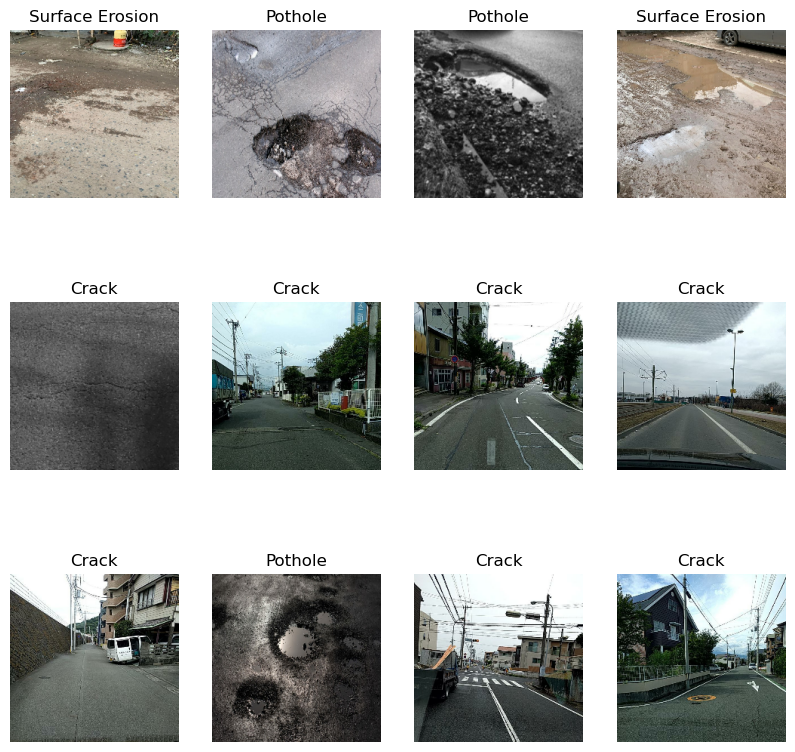

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 32
Validation data size: 4
Test data size: 5


In [9]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

32
4
5


In [10]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2)
])

In [13]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [14]:
model = build_vgg19_model()

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 265s 8s/step - accuracy: 0.4638 - loss: 1.0178 - val_accuracy: 0.7188 - val_loss: 0.7941
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.6950 - loss: 0.7552 - val_accuracy: 0.7500 - val_loss: 0.6859
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 236s 7s/step - accuracy: 0.7066 - loss: 0.6776 - val_accuracy: 0.7344 - val_loss: 0.6412
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.7334 - loss: 0.6384 - val_accuracy: 0.7578 - val_loss: 0.6708
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.7628 - loss: 0.6104 - val_accuracy: 0.7656 - val_loss: 0.5974
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.7137 - loss: 0.6401 - val_accuracy: 0.8047 - val_loss: 0.5853
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.7561 - loss: 0.5905 - val_accuracy: 0.7422 - val_loss: 0.6079
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 276s 9s/step - accuracy: 0.7437 - loss: 0.5811 - val_accuracy: 0.7969 - v

In [18]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.8459 - loss: 0.4415


[0.37689918279647827, 0.875]

In [19]:
model.save("trained_model/VGG19v1.o.h5")
model.save("trained_model/VGG19v1.o.keras")

In [20]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 32}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
history.history['accuracy']

[0.5546719431877136,
 0.6948310136795044,
 0.7047713994979858,
 0.737574577331543,
 0.7445328235626221,
 0.749502956867218,
 0.7534791231155396,
 0.7574552893638611,
 0.789264440536499,
 0.775347888469696,
 0.7713717818260193,
 0.7882703542709351,
 0.7862823009490967,
 0.794234573841095,
 0.7842942476272583,
 0.7852882742881775,
 0.8051689863204956,
 0.794234573841095,
 0.7982107400894165,
 0.8161033987998962,
 0.8061630129814148,
 0.8111332058906555,
 0.8111332058906555,
 0.807157039642334,
 0.8061630129814148,
 0.8240556716918945,
 0.8339959979057312,
 0.8339959979057312,
 0.8280318379402161,
 0.833001971244812,
 0.8310139179229736,
 0.8439363837242126,
 0.8339959979057312,
 0.8320079445838928,
 0.8409543037414551,
 0.845924437046051,
 0.8349900841712952,
 0.8349900841712952,
 0.8439363837242126,
 0.8578528761863708,
 0.8538767099380493,
 0.8538767099380493,
 0.8568588495254517,
 0.8538767099380493,
 0.85884690284729,
 0.85884690284729,
 0.8598409295082092,
 0.8697813153266907,
 0.86

In [23]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
F1 Score (macro): 0.8746924783222424
F1 Score (weighted): 0.8770674531155475

Classification Report:

                 precision    recall  f1-score   support

          Crack       1.00      0.87      0.93        61
        Pothole       0.83      0.91      0.87        43
Surface Erosion       0.80      0.86      0.83        56

       accuracy                           0.88       160
      macro avg       0.88      0.88      0.87       160
   weighted avg       0.88      0.88      0.88       160



In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

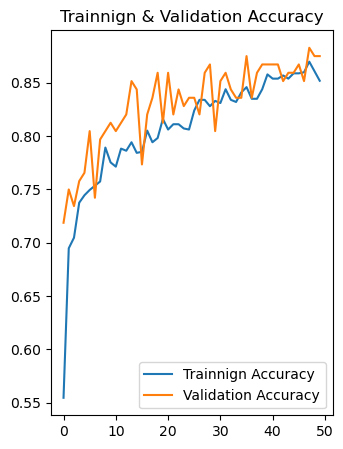

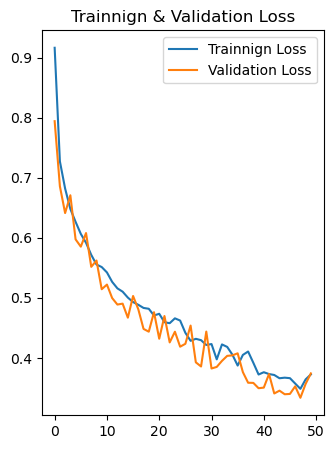

In [25]:

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [26]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.8854 - loss: 0.3467


[0.37689918279647827, 0.875]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Label:  Surface Erosion


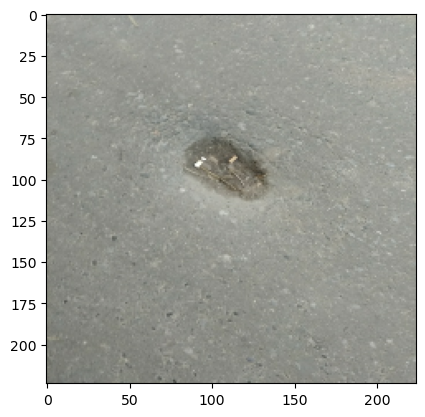

In [27]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->52.42 Light:-> Normal lighting
Confidence:->69.4 Light:-> Normal lighting
Confidence:->95.98 Light:-> Normal lighting
Confidence:->50.86 Light:-> Normal lighting
Confidence:->74.78 Light:-> Normal lighting
Confidence:->49.51 Light:-> Normal lighting
Confidence:->83.76 Light:-> Normal lighting
Confidence:->62.65 Light:-> Low light
Confidence:->78.78 Light:-> Normal lighting


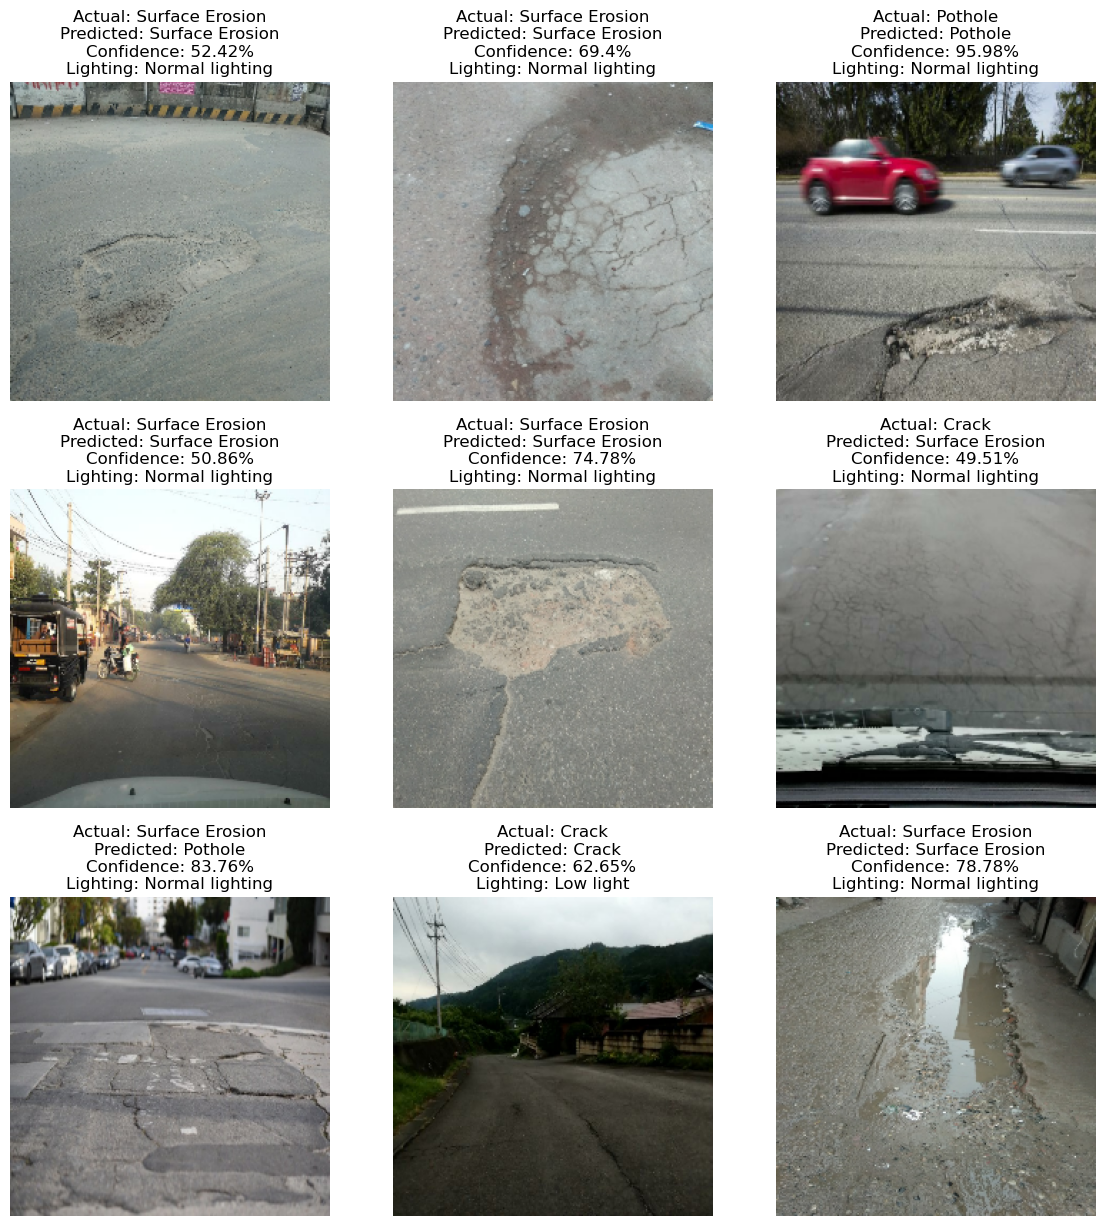

In [29]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [30]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 78.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


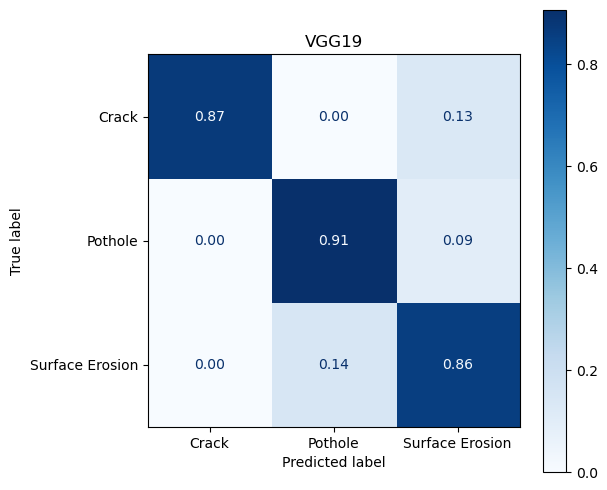

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("VGG19")
plt.savefig("D:\\Masrafe\\Coding\\Git_Hub_code\\ml_project\\road_damage\\test_results\\vgg19_0.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


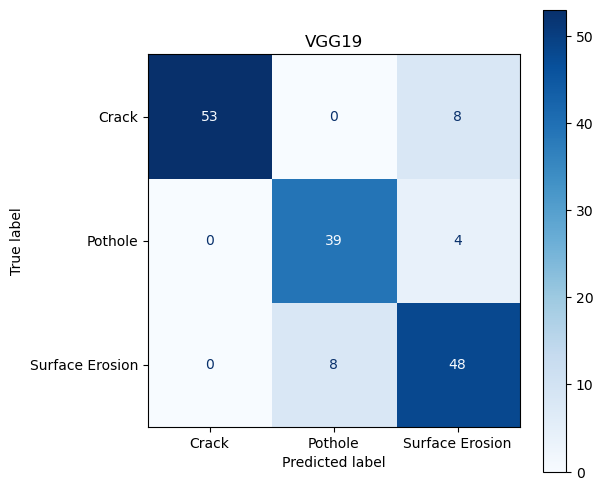

In [33]:
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")  # "d" for integer values
plt.title("VGG19")
plt.savefig("D:\\Masrafe\\Coding\\Git_Hub_code\\ml_project\\road_damage\\test_results\\vgg19_00.png", dpi=300, bbox_inches='tight')
plt.show()